In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb

import scipy as sp
from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators


import gc
%matplotlib inline

In [2]:
%time
train_df = pd.read_csv(os.path.join("../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [3]:
train_df.shape

(629145480, 2)

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [9]:
#Prepare empty frame
train_X = pd.DataFrame(index=range(segments), dtype=np.float32)
train_y = pd.DataFrame(index=range(segments), dtype=np.float32, columns=['time_to_failure'])

In [15]:
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"].astype(np.float32)
    

    X.loc[seg_id,"num_peaks_1"] = feature_calculators.number_peaks(xc,1)
    X.loc[seg_id,"num_peaks_5"] = feature_calculators.number_peaks(xc,5)
    X.loc[seg_id,"num_peaks_10"] = feature_calculators.number_peaks(xc,10)
    
    X.loc[seg_id,"cid_ce_1"] = feature_calculators.cid_ce(xc, 1)
    
    X.loc[seg_id,'moment_4'] = sp.stats.moment(xc, 4)
    X.loc[seg_id,'moment_2'] = sp.stats.moment(xc, 2)
    
    X.loc[seg_id,"range_m1000_0"] = feature_calculators.range_count(xc, -1000, 0)
    X.loc[seg_id,"c_5"] = feature_calculators.c3(xc, 5)
    X.loc[seg_id,"mean"] = xc.mean()
    X.loc[seg_id,"binned_entropy_5"] = feature_calculators.binned_entropy(xc, 5)
    X.loc[seg_id,"autocorrelation_10"] = feature_calculators.autocorrelation(xc, 10)
    
    
    window_size = 10
    xc_rolled = xc.rolling(window_size)
    xc_rolled_var = xc_rolled.var().dropna()
    xc_rolled_mean = xc_rolled.mean().dropna()
        
    window_str = str(window_size)

    X.loc[seg_id,"rollingMean"+window_str+"_quantile_4"] = xc_rolled_mean.quantile(0.04)
    rolled_var_quantiles = xc_rolled_var.quantile([0.01,0.04])
    X.loc[seg_id,"rollingVar"+window_str+"_quantile_4"] = rolled_var_quantiles[0.04]
    X.loc[seg_id,"rollingVar"+window_str+"_quantile_1"] = rolled_var_quantiles[0.01]
    
    window_size = 10
    window_str = str(window_size)
    xc_rolled = xc.rolling(300)
    xc_rolled_var = xc_rolled.var().dropna()
    X.loc[seg_id,"rollingVar"+window_str+"_quantile_2"] = xc_rolled_var.quantile(0.02)

In [16]:
#create features from train
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]    

In [ ]:
#create features from test
segment_names = [file for file in os.listdir("../input") if file.startswith("seg")]
test_df = pd.DataFrame(index=segment_names, dtype=np.float32)
test_df.index = test_df.index.str[:-4]
for file in tqdm_notebook(segment_names):
    seg_id = file[:-4]
    segment = pd.read_csv(os.path.join("../input",file),dtype={'acoustic_data': np.int16})
    create_features(seg_id,segment,test_df)


In [12]:
train_X.head()

,num_peaks_1,num_peaks_5,num_peaks_10,cid_ce_1,moment_4,moment_2,range_m1000_0,c_5,mean,binned_entropy_5,autocorrelation_10,rollingMean10_quantile_4,rollingVar10_quantile_4,rollingVar10_quantile_1,rollingVar10_quantile_2
0,31523.0,8640.0,5470.0,257.823936,24823.312530,26.021110,11570.0,49.297453,4.884113,0.050021,-0.469692,1.3,2.488889,1.600000,6.413144
1,31292.0,8596.0,5474.0,216.043788,191770.733203,43.412309,13365.0,35.327549,4.725767,0.040129,-0.450367,0.7,2.500000,1.655556,6.417793
2,30706.0,8494.0,5549.0,208.748440,86141.411280,48.544298,14251.0,30.544036,4.906393,0.132877,-0.480152,0.0,2.622222,1.733333,6.739086
3,31320.0,8592.0,5458.0,207.457707,274489.577511,47.917990,12609.0,57.539696,4.902240,0.033637,-0.374296,0.8,2.544444,1.611111,6.554504
4,31302.0,8483.0,5381.0,194.230870,159056.876454,53.305855,12822.0,69.801620,4.908720,0.082438,-0.385905,0.4,2.500000,1.611111,6.401906


In [13]:
pd.read_csv(os.path.join("../extracted_feat/","train_x_89_no_eq.csv")).head()

,num_peaks_1,num_peaks_5,num_peaks_10,cid_ce_1,moment_4,moment_2,range_m1000_0,c_5,whole_mean,rollingVar_4_quantile10,autocorrelation_10,rollingMean_4_quantile10,rollingVar_2_quantile300,rollingVar_1_quantile10,binned_entropy_5
0,31523.0,8640.0,5470.0,257.823936,24823.312530,26.021110,11570.0,49.297453,4.884113,2.488889,-0.469692,1.3,6.413144,1.600000,0.050021
1,31292.0,8596.0,5474.0,216.043788,191770.733203,43.412309,13365.0,35.327549,4.725767,2.500000,-0.450367,0.7,6.417793,1.655556,0.040129
2,30706.0,8494.0,5549.0,208.748440,86141.411280,48.544298,14251.0,30.544036,4.906393,2.622222,-0.480152,0.0,6.739086,1.733333,0.132877
3,31320.0,8592.0,5458.0,207.457707,274489.577511,47.917990,12609.0,57.539696,4.902240,2.544444,-0.374296,0.8,6.554504,1.611111,0.033637
4,31302.0,8483.0,5381.0,194.230870,159056.876454,53.305855,12822.0,69.801620,4.908720,2.500000,-0.385905,0.4,6.401906,1.611111,0.082438


In [16]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
params = {
    'lambda_l1': 0.012465994599126015, 
    'bagging_freq': 15, 
    'verbose': -1, 
    'min_data_in_leaf': 5, 
    'feature_fraction': 0.7143153769050614, 
    'objective': 'MAE',
    'lambda_l2': 0.055052283158846985, 
    'metric': 'MAE', 
    'bagging_fraction': 0.4871803105884792,
    'max_depth': -1, 
    'learning_rate': 0.007017896834582354, 
    'boosting_type': 'gbdt', 
    'num_leaves': 9
}

In [17]:
def train_lgb(train_X,train_y,test_df,params,folds):
    features_importance = pd.DataFrame({"features":train_X.columns,
                                        "importance":np.zeros(train_X.columns.shape[0])})
    predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
    oof = np.zeros(train_X.shape[0])

    for train_idx,val_idx in folds.split(train_X,train_y):
        X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
        X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
        model.fit(X_train,y_train,
                  eval_set=[(X_train,y_train),(X_val,y_val)], 
                  verbose=1000,
                  early_stopping_rounds=1000)

        oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

        features_importance["importance"] += model.feature_importances_
        predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_)
    return oof,predictions,features_importance

oof,predictions,features_importance = train_lgb(train_X,train_y,test_df,params,folds)

Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.82506	valid_1's l1: 2.02927
[2000]	training's l1: 1.71562	valid_1's l1: 2.03225
Early stopping, best iteration is:
[1755]	training's l1: 1.73636	valid_1's l1: 2.02764
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.82308	valid_1's l1: 2.06293
[2000]	training's l1: 1.71012	valid_1's l1: 2.05827
Early stopping, best iteration is:
[1717]	training's l1: 1.73559	valid_1's l1: 2.05458
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.83842	valid_1's l1: 2.00059
[2000]	training's l1: 1.73393	valid_1's l1: 1.99801
Early stopping, best iteration is:
[1932]	training's l1: 1.74027	valid_1's l1: 1.99597
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 1.84144	valid_1's l1: 1.95925
Early stopping, best iteration is:
[857]	training's l1: 1.86258	valid_1's l1: 1.95661
Training until validation scores 

In [18]:
mean_absolute_error(train_y,oof)

2.0151349491722423

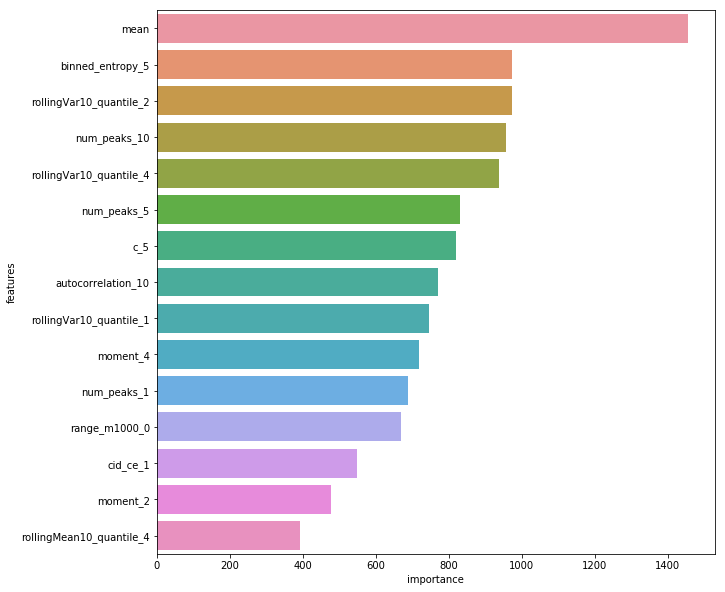

In [19]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5

plt.figure(figsize=(10,10))
ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))

In [25]:
predictions[predictions["seg_id"]=="seg_9e7dff"]

,seg_id,time_to_failure
1306,seg_9e7dff,3.769938


In [26]:
predictions.to_csv("../submissions/submission_lgb_15_col.csv",index=False)
# pd.DataFrame(oof).to_csv("../oof/oof_lgb_15_col.csv",index=False)